In [51]:
!pip install mlflow

In [52]:
!pip install databricks-sdk

In [53]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, model_from_json  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from math import ceil
from sklearn.preprocessing import LabelEncoder

# Data Preprocessing

In [54]:
def preprocess_data(train_dir, test_dir):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for emotion_class in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, emotion_class)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
            img_array = img_to_array(img)
            train_data.append(img_array)
            train_labels.append(emotion_class)

    for emotion_class in os.listdir(test_dir):
        class_dir = os.path.join(test_dir, emotion_class)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
            img_array = img_to_array(img)
            test_data.append(img_array)
            test_labels.append(emotion_class)

    # Convert data and labels to numpy arrays
    X_train = np.array(train_data).astype('float32') / 255.0  # Normalize pixel values
    y_train = np.array(train_labels)

    X_test = np.array(test_data).astype('float32') / 255.0  # Normalize pixel values
    y_test = np.array(test_labels)

    # Encode labels (if class names are used as labels)
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    
    print("Pre-processing completed")
    return X_train, y_train, X_test, y_test


In [55]:
from sklearn.model_selection import train_test_split

def split_data(X_train, y_train):
    
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    print("Split done")
    return x_train, x_val, y_train, y_val

In [56]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

X_train, y_train, X_test, y_test = preprocess_data(train_dir, test_dir)
x_train, x_val, y_train, y_val = split_data(X_train, y_train)

Pre-processing completed
Split done


# Plots

In [57]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc='upper right')
    plt.show()

In [58]:
def convert_to_rgb(images):
    
    images_reshaped = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
    images_rgb = np.repeat(images_reshaped, 3, axis=3)
    return images_rgb

# VGGNet Model

In [59]:
import numpy as np
from skimage.color import gray2rgb
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def define_vgg_model(input_shape=(48, 48, 3), classes=7, trainable=True):
    
    if input_shape[-1] == 3:
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)

    if not trainable:
        for layer in base_model.layers:
            layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [60]:
def run_vgg_model(x_train, x_val, y_train, y_val, X_test, y_test, model, epochs, batch_size):
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_steps=len(x_val) // batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print("Run completed")
    return history, test_loss, test_acc


In [98]:
x_train_rgb = convert_to_rgb(x_train)
x_val_rgb = convert_to_rgb(x_val)
X_test_rgb = convert_to_rgb(X_test)

vgg_model = define_vgg_model(input_shape=(48, 48, 3), classes=7)

history_vgg, test_loss, test_acc = run_vgg_model(x_train_rgb, x_val_rgb, y_train, y_val, X_test_rgb, y_test, vgg_model, epochs=50, batch_size=32)

print(f"Accuracy obtained in VGGNet model is {test_acc*100} %")

2024/04/01 16:45:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74359490e3d84b98af179d3c9f9312c6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/01 16:45:15 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_10' has no defined input shape yet.
2024/04/01 16:45:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.1172 - loss: 2.2682  

W0000 00:00:1711989926.158860     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


427/717 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.2450 - loss: 1.8492

W0000 00:00:1711989946.499684     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2668 - loss: 1.7967

W0000 00:00:1711989958.791875     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024/04/01 16:46:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.2669 - loss: 1.7964 - val_accuracy: 0.4518 - val_loss: 1.4012
Epoch 2/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.3750 - loss: 1.4701

2024/04/01 16:46:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3750 - loss: 1.4701 - val_accuracy: 0.4573 - val_loss: 1.3902
Epoch 3/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4289 - loss: 1.4439

2024/04/01 16:46:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4289 - loss: 1.4439 - val_accuracy: 0.4988 - val_loss: 1.2794
Epoch 4/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.4062 - loss: 1.5155

2024/04/01 16:46:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4062 - loss: 1.5155 - val_accuracy: 0.5073 - val_loss: 1.2704
Epoch 5/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4910 - loss: 1.3195

2024/04/01 16:47:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4911 - loss: 1.3194 - val_accuracy: 0.5385 - val_loss: 1.2089
Epoch 6/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.1050 - val_accuracy: 0.5355 - val_loss: 1.2178
Epoch 7/50
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5321 - loss: 1.2427

2024/04/01 16:47:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5321 - loss: 1.2427 - val_accuracy: 0.5629 - val_loss: 1.1644
Epoch 8/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.4062 - loss: 1.5734

2024/04/01 16:47:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4062 - loss: 1.5734 - val_accuracy: 0.5601 - val_loss: 1.1631
Epoch 9/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5523 - loss: 1.2028

2024/04/01 16:48:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5523 - loss: 1.2028 - val_accuracy: 0.5792 - val_loss: 1.1151
Epoch 10/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5625 - loss: 1.1051 - val_accuracy: 0.5721 - val_loss: 1.1271
Epoch 11/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5745 - loss: 1.1538

2024/04/01 16:49:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.5745 - loss: 1.1539 - val_accuracy: 0.6015 - val_loss: 1.0616
Epoch 12/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.7563 - val_accuracy: 0.6015 - val_loss: 1.0628
Epoch 13/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5859 - loss: 1.1174

2024/04/01 16:49:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.5859 - loss: 1.1174 - val_accuracy: 0.6012 - val_loss: 1.0552
Epoch 14/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5000 - loss: 1.2965

2024/04/01 16:49:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5000 - loss: 1.2965 - val_accuracy: 0.6034 - val_loss: 1.0512
Epoch 15/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5995 - loss: 1.0721

2024/04/01 16:50:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.5995 - loss: 1.0721 - val_accuracy: 0.6263 - val_loss: 1.0202
Epoch 16/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6875 - loss: 1.0133 - val_accuracy: 0.6257 - val_loss: 1.0241
Epoch 17/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6115 - loss: 1.0501 - val_accuracy: 0.5907 - val_loss: 1.0847
Epoch 18/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4375 - loss: 1.2634

2024/04/01 16:50:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4375 - loss: 1.2634 - val_accuracy: 0.5958 - val_loss: 1.0808
Epoch 19/50
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6314 - loss: 1.0155

2024/04/01 16:51:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.6314 - loss: 1.0155 - val_accuracy: 0.6226 - val_loss: 1.0019
Epoch 20/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.1771 - val_accuracy: 0.6226 - val_loss: 1.0034
Epoch 21/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6306 - loss: 1.0043

2024/04/01 16:51:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6306 - loss: 1.0043 - val_accuracy: 0.6301 - val_loss: 0.9948
Epoch 22/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.2644 - val_accuracy: 0.6271 - val_loss: 1.0004
Epoch 23/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6394 - loss: 0.9768

2024/04/01 16:52:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6394 - loss: 0.9768 - val_accuracy: 0.6296 - val_loss: 0.9885
Epoch 24/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.1454 - val_accuracy: 0.6284 - val_loss: 0.9891
Epoch 25/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6606 - loss: 0.9271

2024/04/01 16:53:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.6606 - loss: 0.9271 - val_accuracy: 0.6294 - val_loss: 0.9751
Epoch 26/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6250 - loss: 0.9826 - val_accuracy: 0.6289 - val_loss: 0.9765
Epoch 27/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6602 - loss: 0.9257 - val_accuracy: 0.6379 - val_loss: 0.9991
Epoch 28/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 0.9864 - val_accuracy: 0.6338 - val_loss: 1.0062
Epoch 29/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6617 - loss: 0.9165

2024/04/01 16:54:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6617 - loss: 0.9165 - val_accuracy: 0.6484 - val_loss: 0.9579
Epoch 30/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.6562 - loss: 0.8310

2024/04/01 16:54:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6562 - loss: 0.8310 - val_accuracy: 0.6465 - val_loss: 0.9573
Epoch 31/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6782 - loss: 0.8847 - val_accuracy: 0.6235 - val_loss: 1.0085
Epoch 32/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5312 - loss: 1.2802

2024/04/01 16:54:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5312 - loss: 1.2802 - val_accuracy: 0.6252 - val_loss: 1.0026
Epoch 33/50
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6857 - loss: 0.8737

2024/04/01 16:55:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6857 - loss: 0.8737 - val_accuracy: 0.6400 - val_loss: 0.9804
Epoch 34/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7500 - loss: 0.8298 - val_accuracy: 0.6383 - val_loss: 0.9837
Epoch 35/50
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6902 - loss: 0.8482

2024/04/01 16:55:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.6902 - loss: 0.8482 - val_accuracy: 0.6440 - val_loss: 0.9731
Epoch 36/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.7795 - val_accuracy: 0.6442 - val_loss: 0.9756
Epoch 37/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7015 - loss: 0.8254

2024/04/01 16:56:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.7014 - loss: 0.8254 - val_accuracy: 0.6588 - val_loss: 0.9475
Epoch 38/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.5312 - loss: 1.2457

2024/04/01 16:56:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5312 - loss: 1.2457 - val_accuracy: 0.6604 - val_loss: 0.9462
Epoch 39/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.7025 - loss: 0.8158 - val_accuracy: 0.6423 - val_loss: 1.0190
Epoch 40/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.7188 - loss: 0.8352

2024/04/01 16:57:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7188 - loss: 0.8352 - val_accuracy: 0.6430 - val_loss: 1.0127
Epoch 41/50
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7100 - loss: 0.7923

2024/04/01 16:57:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.7100 - loss: 0.7924 - val_accuracy: 0.6543 - val_loss: 0.9850
Epoch 42/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 0.7114 - val_accuracy: 0.6508 - val_loss: 0.9894
Epoch 43/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7207 - loss: 0.7733

2024/04/01 16:58:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.7207 - loss: 0.7733 - val_accuracy: 0.6524 - val_loss: 0.9766
Epoch 44/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6250 - loss: 1.0778 - val_accuracy: 0.6503 - val_loss: 0.9773
Epoch 45/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.7233 - loss: 0.7600 - val_accuracy: 0.6595 - val_loss: 0.9880
Epoch 46/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.9001 - val_accuracy: 0.6599 - val_loss: 0.9895
Epoch 47/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7312 - loss: 0.7340

2024/04/01 16:59:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.7312 - loss: 0.7340 - val_accuracy: 0.6566 - val_loss: 0.9539
Epoch 48/50
  1/717 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.7812 - loss: 0.5725

2024/04/01 16:59:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7812 - loss: 0.5725 - val_accuracy: 0.6583 - val_loss: 0.9530
Epoch 49/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.7357 - loss: 0.7236 - val_accuracy: 0.6606 - val_loss: 0.9777
Epoch 50/50
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8750 - loss: 0.4289 - val_accuracy: 0.6628 - val_loss: 0.9792


2024/04/01 17:00:02 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/04/01 17:00:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/04/01 17:00:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpop62nh8g/model/data/model.


 16/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8082 - loss: 0.7328

W0000 00:00:1711990804.085597     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6389 - loss: 1.0752
Run completed
Accuracy obtained in VGGNet model is 66.57843589782715 %


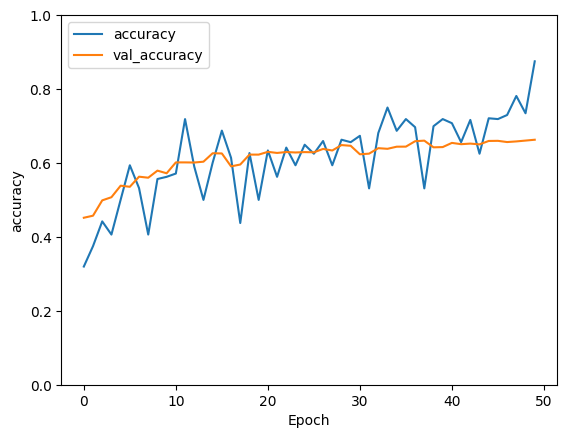

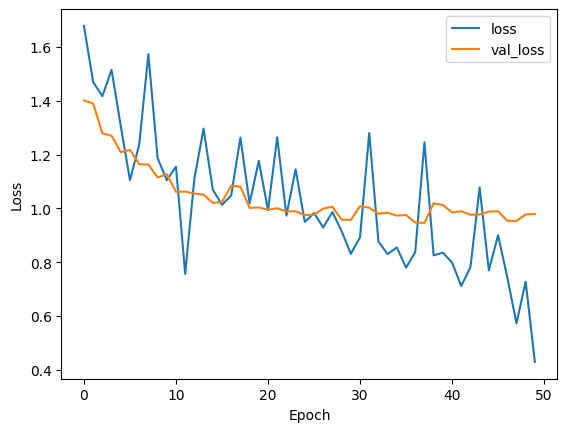

In [99]:
plot_acc_loss(history_vgg)

In [63]:
import mlflow
mlflow.login()

2024/04/01 14:46:41 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [64]:
import numpy as np

# Assuming x_train_rgb is a NumPy array
if np.any(np.isnan(x_train_rgb)):
    print("Input data contains NaN values.")
elif np.any(x_train_rgb == None):
    print("Input data contains None values.")
else:
    print("Input data is properly formatted.")


Input data is properly formatted.


In [65]:
x_train_rgb.shape

(22967, 48, 48, 3)

In [66]:
x_train_rgb[0]

array([[[0.53333336, 0.53333336, 0.53333336],
        [0.65882355, 0.65882355, 0.65882355],
        [0.5921569 , 0.5921569 , 0.5921569 ],
        ...,
        [0.20392157, 0.20392157, 0.20392157],
        [0.22352941, 0.22352941, 0.22352941],
        [0.23137255, 0.23137255, 0.23137255]],

       [[0.5529412 , 0.5529412 , 0.5529412 ],
        [0.6039216 , 0.6039216 , 0.6039216 ],
        [0.6156863 , 0.6156863 , 0.6156863 ],
        ...,
        [0.1764706 , 0.1764706 , 0.1764706 ],
        [0.22352941, 0.22352941, 0.22352941],
        [0.21568628, 0.21568628, 0.21568628]],

       [[0.6431373 , 0.6431373 , 0.6431373 ],
        [0.59607846, 0.59607846, 0.59607846],
        [0.6509804 , 0.6509804 , 0.6509804 ],
        ...,
        [0.25882354, 0.25882354, 0.25882354],
        [0.13333334, 0.13333334, 0.13333334],
        [0.22745098, 0.22745098, 0.22745098]],

       ...,

       [[0.6156863 , 0.6156863 , 0.6156863 ],
        [0.61960787, 0.61960787, 0.61960787],
        [0.6156863 , 0

# DenseNet Model

In [67]:
from tensorflow.keras.applications import DenseNet121

def define_densenet_model(input_shape=(48, 48, 3), classes=7, trainable=True):
    
    if input_shape[-1] == 1:  # Assuming grayscale input
        x_train_rgb = np.array([gray2rgb(img) for img in x_train])
        x_val_rgb = np.array([gray2rgb(img) for img in x_val])
        X_test_rgb = np.array([gray2rgb(img) for img in X_test])
    else:
        x_train_rgb = x_train
        x_val_rgb = x_val
        X_test_rgb = X_test

    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    if not trainable:
        for layer in base_model.layers:
            layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model


In [68]:
def run_densenet_model(x_train, x_val, y_train, y_val, X_test, y_test, model, epochs, batch_size):
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_steps=len(x_val) // batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print("Run completed")
    return history, test_loss, test_acc


In [69]:
x_train_rgb = convert_to_rgb(x_train)
x_val_rgb = convert_to_rgb(x_val)
X_test_rgb = convert_to_rgb(X_test)

densenet_model = define_densenet_model(input_shape=(48, 48, 3), classes=7)

history_densenet, test_loss, test_acc = run_densenet_model(x_train_rgb, x_val_rgb, y_train, y_val, X_test_rgb, y_test, densenet_model, epochs=30, batch_size=32)

print(f"Accuracy obtained in DenseNet model is {test_acc*100} %")

2024/04/01 14:46:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8931aa1e7f31474f995a71cdd48197a9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/01 14:46:59 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_5' has no defined input shape yet.
2024/04/01 14:46:59 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/30


W0000 00:00:1711982938.482577     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


542/717 ━━━━━━━━━━━━━━━━━━━━ 26s 152ms/step - accuracy: 0.2067 - loss: 2.0883

W0000 00:00:1711983021.971274     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2134 - loss: 2.0480

W0000 00:00:1711983038.596393     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024/04/01 14:50:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 222s 146ms/step - accuracy: 0.2134 - loss: 2.0476 - val_accuracy: 0.3509 - val_loss: 1.6653
Epoch 2/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.3750 - loss: 1.8341

2024/04/01 14:50:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3750 - loss: 1.8341 - val_accuracy: 0.3527 - val_loss: 1.6639
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3314 - loss: 1.6874

2024/04/01 14:51:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.3315 - loss: 1.6874 - val_accuracy: 0.4488 - val_loss: 1.4282
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4375 - loss: 1.6433 - val_accuracy: 0.4493 - val_loss: 1.4290
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4105 - loss: 1.5215

2024/04/01 14:52:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.4105 - loss: 1.5214 - val_accuracy: 0.4815 - val_loss: 1.3485
Epoch 6/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 0.5000 - loss: 1.2087

2024/04/01 14:52:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5000 - loss: 1.2087 - val_accuracy: 0.4819 - val_loss: 1.3467
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4631 - loss: 1.4146 - val_accuracy: 0.4754 - val_loss: 1.3899
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.3882 - val_accuracy: 0.4744 - val_loss: 1.3931
Epoch 9/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4819 - loss: 1.3537

2024/04/01 14:53:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.4819 - loss: 1.3537 - val_accuracy: 0.5235 - val_loss: 1.2653
Epoch 10/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 1.2340 - val_accuracy: 0.5246 - val_loss: 1.2661
Epoch 11/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5032 - loss: 1.3092

2024/04/01 14:53:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5032 - loss: 1.3092 - val_accuracy: 0.5387 - val_loss: 1.2093
Epoch 12/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6250 - loss: 1.2268 - val_accuracy: 0.5388 - val_loss: 1.2101
Epoch 13/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5259 - loss: 1.2620

2024/04/01 14:54:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5259 - loss: 1.2620 - val_accuracy: 0.5547 - val_loss: 1.2076
Epoch 14/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.3537 - val_accuracy: 0.5542 - val_loss: 1.2131
Epoch 15/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5337 - loss: 1.2426

2024/04/01 14:55:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5337 - loss: 1.2426 - val_accuracy: 0.5655 - val_loss: 1.1914
Epoch 16/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6875 - loss: 1.0968 - val_accuracy: 0.5641 - val_loss: 1.1924
Epoch 17/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5544 - loss: 1.1972 - val_accuracy: 0.5526 - val_loss: 1.3733
Epoch 18/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.5000 - loss: 1.1923

2024/04/01 14:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5000 - loss: 1.1923 - val_accuracy: 0.5542 - val_loss: 1.3713
Epoch 19/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5614 - loss: 1.1753

2024/04/01 14:56:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5614 - loss: 1.1752 - val_accuracy: 0.5883 - val_loss: 1.1152
Epoch 20/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 0.6250 - loss: 1.1721

2024/04/01 14:56:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6250 - loss: 1.1721 - val_accuracy: 0.5883 - val_loss: 1.1150
Epoch 21/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5838 - loss: 1.1296

2024/04/01 14:57:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5838 - loss: 1.1296 - val_accuracy: 0.5836 - val_loss: 1.0970
Epoch 22/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.7958 - val_accuracy: 0.5832 - val_loss: 1.0984
Epoch 23/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5819 - loss: 1.1290

2024/04/01 14:57:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.5819 - loss: 1.1289 - val_accuracy: 0.6008 - val_loss: 1.0683
Epoch 24/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 0.6562 - loss: 1.1452

2024/04/01 14:57:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6562 - loss: 1.1452 - val_accuracy: 0.6010 - val_loss: 1.0683
Epoch 25/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5978 - loss: 1.0926

2024/04/01 14:58:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.5978 - loss: 1.0926 - val_accuracy: 0.5991 - val_loss: 1.0656
Epoch 26/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 0.5000 - loss: 1.0601

2024/04/01 14:58:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5000 - loss: 1.0601 - val_accuracy: 0.5996 - val_loss: 1.0651
Epoch 27/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6044 - loss: 1.0746

2024/04/01 14:59:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.6044 - loss: 1.0746 - val_accuracy: 0.6170 - val_loss: 1.0377
Epoch 28/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 0.9881 - val_accuracy: 0.6158 - val_loss: 1.0427
Epoch 29/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6168 - loss: 1.0386

2024/04/01 14:59:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.6168 - loss: 1.0387 - val_accuracy: 0.6122 - val_loss: 1.0372
Epoch 30/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5625 - loss: 1.1831 - val_accuracy: 0.6127 - val_loss: 1.0381


2024/04/01 14:59:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/04/01 14:59:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/04/01 14:59:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpgn6768aj/model/data/model.


 10/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8312 - loss: 0.6533

W0000 00:00:1711983598.319511     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.5953 - loss: 1.0659
Run completed
Accuracy obtained in DenseNet model is 61.66062951087952 %


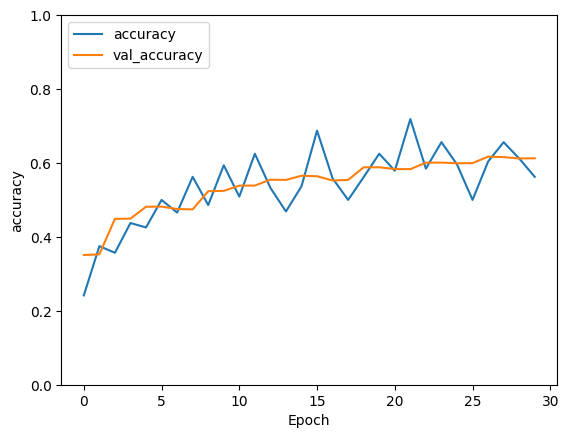

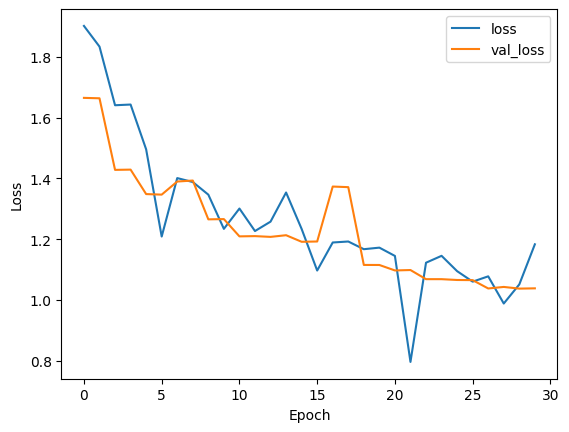

In [70]:
plot_acc_loss(history_densenet)

In [71]:
# mlflow.set_experiment("/DenseNet Model-1")
# mlflow.tensorflow.autolog()

# densenet_model.fit(x_train_rgb, epochs=5)

# ResNet Model

In [72]:
from tensorflow.keras.applications import ResNet50

def define_resnet_model(input_shape=(48, 48, 3), classes=7, trainable=True):
    
    if input_shape[-1] == 1:  # Assuming grayscale input
        x_train_rgb = np.array([gray2rgb(img) for img in x_train])
        x_val_rgb = np.array([gray2rgb(img) for img in x_val])
        X_test_rgb = np.array([gray2rgb(img) for img in X_test])
    else:
        x_train_rgb = x_train
        x_val_rgb = x_val
        X_test_rgb = X_test

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    if not trainable:
        for layer in base_model.layers:
            layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [73]:
def run_resnet_model(x_train, x_val, y_train, y_val, X_test, y_test, model, epochs, batch_size):
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_steps=len(x_val) // batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print("Run completed for ResNet Model")
    return history, test_loss, test_acc

In [74]:
x_train_rgb = convert_to_rgb(x_train)
x_val_rgb = convert_to_rgb(x_val)
X_test_rgb = convert_to_rgb(X_test)

resnet_model = define_resnet_model(input_shape=(48, 48, 3), classes=7)

history_resnet, test_loss, test_acc = run_resnet_model(x_train_rgb, x_val_rgb, y_train, y_val, X_test_rgb, y_test, resnet_model, epochs=30, batch_size=32)

print(f"Accuracy obtained in ResNet model is {test_acc*100} %")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


2024/04/01 15:00:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '11acba7239be4b429a2b00cae72f0e3f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/01 15:00:11 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_6' has no defined input shape yet.
2024/04/01 15:00:11 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/30


W0000 00:00:1711983681.974482     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


650/717 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2299 - loss: 2.3267

W0000 00:00:1711983745.961661     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2326 - loss: 2.2961

W0000 00:00:1711983755.550511     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024/04/01 15:02:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 149s 111ms/step - accuracy: 0.2327 - loss: 2.2957 - val_accuracy: 0.2720 - val_loss: 1.8772
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3438 - loss: 1.7029 - val_accuracy: 0.2753 - val_loss: 1.8790
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3330 - loss: 1.6927

2024/04/01 15:03:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.3330 - loss: 1.6926 - val_accuracy: 0.4406 - val_loss: 1.4612
Epoch 4/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.3750 - loss: 1.6095

2024/04/01 15:03:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3750 - loss: 1.6095 - val_accuracy: 0.4417 - val_loss: 1.4607
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3894 - loss: 1.5805

2024/04/01 15:04:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.3895 - loss: 1.5804 - val_accuracy: 0.4861 - val_loss: 1.3661
Epoch 6/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.3750 - loss: 1.4129

2024/04/01 15:04:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3750 - loss: 1.4129 - val_accuracy: 0.4848 - val_loss: 1.3657
Epoch 7/30
312/717 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.4405 - loss: 1.4929

2024/04/01 15:09:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.5447 - loss: 1.2146 - val_accuracy: 0.5803 - val_loss: 1.1341
Epoch 20/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.5000 - loss: 1.2923

2024/04/01 15:09:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5000 - loss: 1.2923 - val_accuracy: 0.5796 - val_loss: 1.1340
Epoch 21/30
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5566 - loss: 1.1919

2024/04/01 15:10:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.5566 - loss: 1.1919 - val_accuracy: 0.5888 - val_loss: 1.1009
Epoch 22/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.5938 - loss: 1.1321

2024/04/01 15:10:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5938 - loss: 1.1321 - val_accuracy: 0.5911 - val_loss: 1.1008
Epoch 23/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5634 - loss: 1.1766

2024/04/01 15:10:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.5634 - loss: 1.1766 - val_accuracy: 0.5862 - val_loss: 1.0963
Epoch 24/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.6875 - loss: 1.0150

2024/04/01 15:10:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6875 - loss: 1.0150 - val_accuracy: 0.5873 - val_loss: 1.0958
Epoch 25/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.5700 - loss: 1.1554 - val_accuracy: 0.5679 - val_loss: 1.1413
Epoch 26/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 1.1569 - val_accuracy: 0.5681 - val_loss: 1.1417
Epoch 27/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5798 - loss: 1.1512

2024/04/01 15:12:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.5798 - loss: 1.1512 - val_accuracy: 0.5991 - val_loss: 1.0744
Epoch 28/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6250 - loss: 1.0287 - val_accuracy: 0.5996 - val_loss: 1.0756
Epoch 29/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.5874 - loss: 1.1317 - val_accuracy: 0.5855 - val_loss: 1.1167
Epoch 30/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.6562 - loss: 0.9044

2024/04/01 15:12:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6562 - loss: 0.9044 - val_accuracy: 0.5857 - val_loss: 1.1145


2024/04/01 15:13:01 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/04/01 15:13:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/04/01 15:13:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmp7xt6p80w/model/data/model.


 11/225 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7626 - loss: 0.7620

W0000 00:00:1711984386.017359     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5691 - loss: 1.1156
Run completed for ResNet Model
Accuracy obtained in ResNet model is 58.94399285316467 %


W0000 00:00:1711984391.913561     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


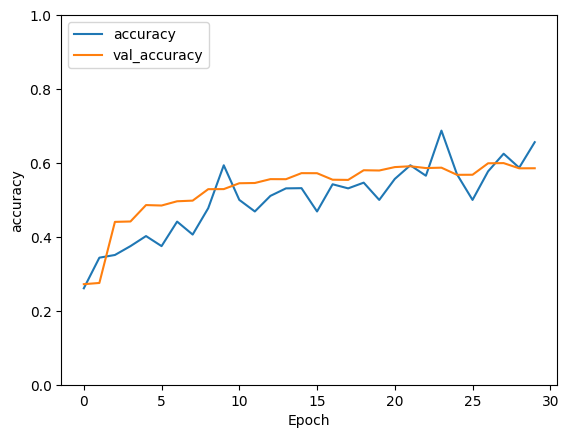

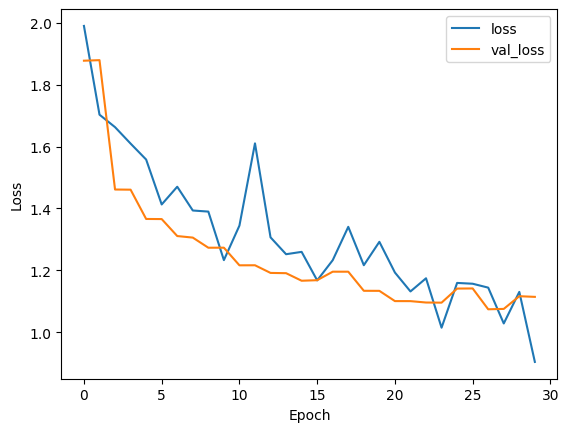

In [75]:
plot_acc_loss(history_resnet)

# MobileNet Model

In [76]:
import numpy as np
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def define_MobileNet_model(base_model, input_shape=(48, 48, 3), classes=7, trainable=True):
    if not trainable:
        base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [77]:
def run_mobilenet_model(x_train, x_val, y_train, y_val, X_test, y_test, model, epochs, batch_size):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_steps=len(x_val) // batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print("Run completed")
    return history, test_loss, test_acc

In [78]:
x_train_rgb = convert_to_rgb(x_train)
x_val_rgb = convert_to_rgb(x_val)
X_test_rgb = convert_to_rgb(X_test)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
model_mobilenet = define_MobileNet_model(base_model, input_shape=(48, 48, 3), classes=7)

history_mobilenet, test_loss, test_acc = run_mobilenet_model(x_train_rgb, x_val_rgb, y_train, y_val, X_test_rgb, y_test, model_mobilenet, epochs=10, batch_size=32)

print(f"Test Accuracy obtained for MobileNetV2: {test_acc*100}")

/tmp/ipykernel_34/218120282.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


2024/04/01 15:13:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a5de05d301e54827a8f7f70e4451f299', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/04/01 15:13:15 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_7' has no defined input shape yet.
2024/04/01 15:13:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/10


W0000 00:00:1711984449.195928     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


255/717 ━━━━━━━━━━━━━━━━━━━━ 1:02 136ms/step - accuracy: 0.1980 - loss: 2.4182

W0000 00:00:1711984484.128277     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2129 - loss: 2.1903

W0000 00:00:1711984504.945547     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024/04/01 15:15:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 114s 87ms/step - accuracy: 0.2129 - loss: 2.1900 - val_accuracy: 0.2612 - val_loss: 1.7899
Epoch 2/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 1.6291 - val_accuracy: 0.2612 - val_loss: 1.7909
Epoch 3/10
715/717 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2877 - loss: 1.7605

2024/04/01 15:15:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.2877 - loss: 1.7604 - val_accuracy: 0.3159 - val_loss: 1.6874
Epoch 4/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3438 - loss: 1.6713 - val_accuracy: 0.3159 - val_loss: 1.6884
Epoch 5/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3295 - loss: 1.6983

2024/04/01 15:16:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.3295 - loss: 1.6983 - val_accuracy: 0.3476 - val_loss: 1.6550
Epoch 6/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3750 - loss: 1.5637 - val_accuracy: 0.3473 - val_loss: 1.6552
Epoch 7/10
715/717 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3508 - loss: 1.6505

2024/04/01 15:16:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.3508 - loss: 1.6505 - val_accuracy: 0.4007 - val_loss: 1.5559
Epoch 8/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5000 - loss: 1.4339

2024/04/01 15:16:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5000 - loss: 1.4339 - val_accuracy: 0.4007 - val_loss: 1.5558
Epoch 9/10
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3738 - loss: 1.6105

2024/04/01 15:17:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.3738 - loss: 1.6105 - val_accuracy: 0.4126 - val_loss: 1.5150
Epoch 10/10
  1/717 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.3750 - loss: 1.5032

2024/04/01 15:17:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to synchronously create dataset (name already exists)


717/717 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3750 - loss: 1.5032 - val_accuracy: 0.4136 - val_loss: 1.5145


2024/04/01 15:17:20 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/04/01 15:17:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/04/01 15:17:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpcipxrgxx/model/data/model.


 24/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6111 - loss: 1.2230

W0000 00:00:1711984644.543883     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3735 - loss: 1.5407
Run completed
Test Accuracy obtained for MobileNetV2: 41.66898727416992


W0000 00:00:1711984649.290044     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


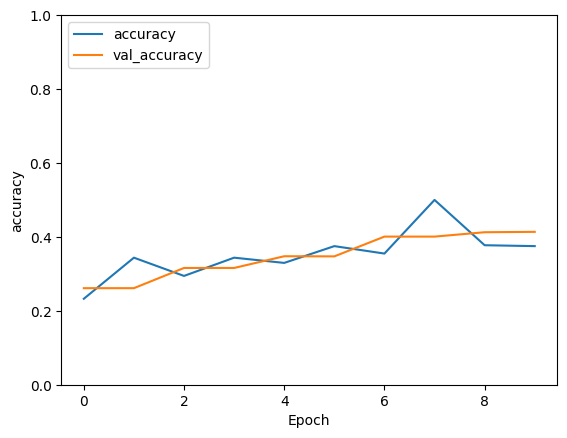

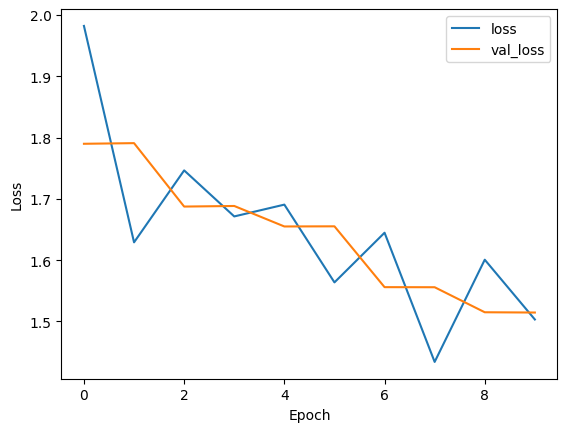

In [79]:
plot_acc_loss(history_mobilenet)

# Sequential (CNN) Model

In [80]:
def Sequential_model(input_shape=(48, 48, 1), classes=7):
    num_features = 64

    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))
    
    print("Sequential Model Training")
    return model

In [81]:
def run_seq_model(x_train, x_val, y_train, y_val, X_test, y_test, epochs, batch_size):
    
    model = Sequential_model(input_shape=x_train[0].shape, classes=len(np.unique(y_train)))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=2)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print("Run completed")
    return history, test_loss, test_acc

In [82]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

epochs = 30
batch_size = 64

X_train, y_train, X_test, y_test = preprocess_data(train_dir, test_dir)
x_train, x_val, y_train, y_val = split_data(X_train, y_train)

history_seq1, test_loss, test_acc = run_seq_model(x_train, x_val, y_train, y_val, X_test, y_test, epochs, batch_size)

print(f"Accuracy obtained in Sequential model is {test_acc*100} %")

Pre-processing completed
Split done


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Sequential Model Training


2024/04/01 15:18:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '500743a8d1a44727b03458143a18d9c8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30


W0000 00:00:1711984704.391204     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711984731.986765     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711984733.172814     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711984737.268035     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 - 57s - 160ms/step - accuracy: 0.3059 - loss: 1.7215 - val_accuracy: 0.1660 - val_loss: 2.2097
Epoch 2/30
359/359 - 18s - 51ms/step - accuracy: 0.4135 - loss: 1.5054 - val_accuracy: 0.3828 - val_loss: 1.5636
Epoch 3/30
359/359 - 19s - 52ms/step - accuracy: 0.4686 - loss: 1.3810 - val_accuracy: 0.4420 - val_loss: 1.4190
Epoch 4/30
359/359 - 18s - 51ms/step - accuracy: 0.5129 - loss: 1.2793 - val_accuracy: 0.4812 - val_loss: 1.3435
Epoch 5/30
359/359 - 18s - 51ms/step - accuracy: 0.5442 - loss: 1.1957 - val_accuracy: 0.4953 - val_loss: 1.3285
Epoch 6/30
359/359 - 18s - 50ms/step - accuracy: 0.5756 - loss: 1.1149 - val_accuracy: 0.5155 - val_loss: 1.2938
Epoch 7/30
359/359 - 14s - 39ms/step - accuracy: 0.6127 - loss: 1.0299 - val_accuracy: 0.5169 - val_loss: 1.3068
Epoch 8/30
359/359 - 14s - 39ms/step - accuracy: 0.6490 - loss: 0.9435 - val_accuracy: 0.4967 - val_loss: 1.3572
Epoch 9/30
359/359 - 18s - 51ms/step - accuracy: 0.6881 - loss: 0.8487 - val_accuracy: 0.5329 - val_loss: 

2024/04/01 15:26:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpzp889fc0/model/data/model.


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5357 - loss: 2.6813
Run completed
Accuracy obtained in Sequential model is 55.182504653930664 %


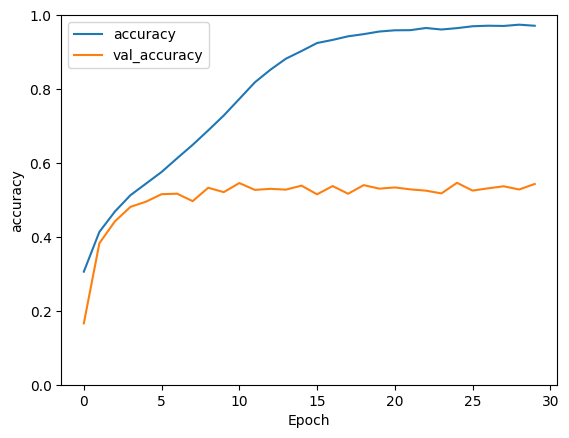

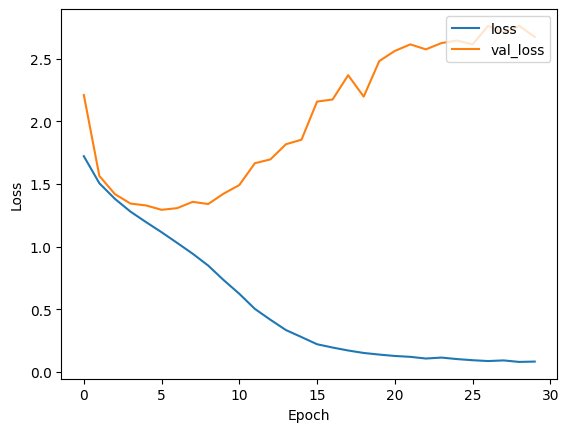

In [83]:
plot_acc_loss(history_seq1)

# Other Sequential Model (using Leaky ReLu)

In [84]:
from keras.layers import LeakyReLU

def Improved_Sequential_model(input_shape=(48, 48, 1), classes=7):
    num_features = 64

    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Conv2D(2 * num_features, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(2 * num_features, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(2 * num_features, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(2 * num_features, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(2 * num_features))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))
    
    print("Improved Sequential Model Training")
    return model

In [85]:
history_seq2, test_loss, test_acc = run_seq_model(x_train, x_val, y_train, y_val, X_test, y_test, epochs, batch_size)

Sequential Model Training


2024/04/01 15:26:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd6b70229cd2b49bb8c5e0cb2a116ad0e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30


W0000 00:00:1711985213.832094     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711985234.120165     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711985235.217139     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711985236.685287     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 - 40s - 111ms/step - accuracy: 0.2905 - loss: 1.7525 - val_accuracy: 0.1674 - val_loss: 2.0202
Epoch 2/30
359/359 - 24s - 68ms/step - accuracy: 0.3959 - loss: 1.5510 - val_accuracy: 0.2492 - val_loss: 1.8154
Epoch 3/30
359/359 - 18s - 51ms/step - accuracy: 0.4497 - loss: 1.4257 - val_accuracy: 0.4248 - val_loss: 1.4924
Epoch 4/30
359/359 - 14s - 38ms/step - accuracy: 0.4923 - loss: 1.3210 - val_accuracy: 0.4316 - val_loss: 1.5133
Epoch 5/30
359/359 - 18s - 50ms/step - accuracy: 0.5322 - loss: 1.2319 - val_accuracy: 0.4678 - val_loss: 1.3901
Epoch 6/30
359/359 - 18s - 51ms/step - accuracy: 0.5669 - loss: 1.1494 - val_accuracy: 0.4998 - val_loss: 1.3428
Epoch 7/30
359/359 - 14s - 40ms/step - accuracy: 0.5959 - loss: 1.0715 - val_accuracy: 0.4829 - val_loss: 1.4202
Epoch 8/30
359/359 - 18s - 51ms/step - accuracy: 0.6385 - loss: 0.9751 - val_accuracy: 0.4819 - val_loss: 1.4191
Epoch 9/30
359/359 - 18s - 50ms/step - accuracy: 0.6773 - loss: 0.8747 - val_accuracy: 0.5190 - val_loss: 

2024/04/01 15:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmp_tc70i6u/model/data/model.


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5308 - loss: 2.8356
Run completed


In [86]:
print(f"Accuracy obtained in Improved Sequential model is {test_acc*100} %")

Accuracy obtained in Improved Sequential model is 55.23822903633118 %


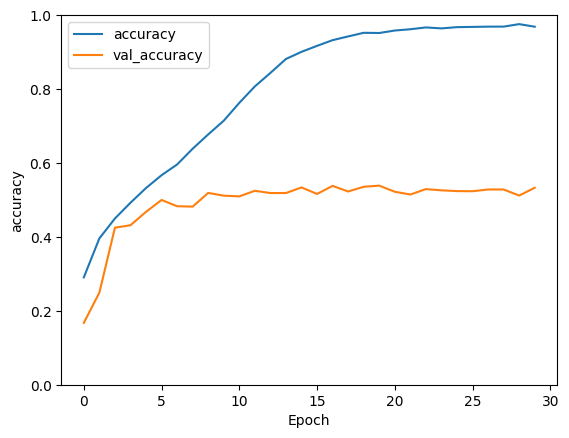

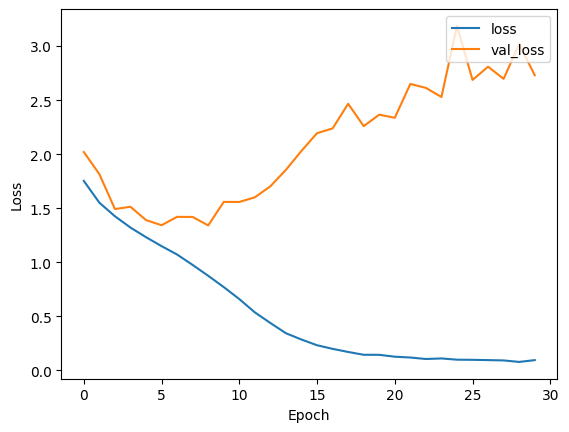

In [89]:
plot_acc_loss(history_seq2)

# Ensembling the Models

In [105]:
weights = {
    'vgg': 0.67,
    'densenet': 0.61,
    'resnet': 0.58
}

X_test_rgb = np.concatenate([X_test] * 3, axis=-1)

vgg_pred = vgg_model.predict(X_test_rgb)
densenet_pred = densenet_model.predict(X_test_rgb)
resnet_pred = resnet_model.predict(X_test_rgb)

ensemble_pred = (weights['vgg'] * vgg_pred + weights['densenet'] * densenet_pred + weights['resnet'] * resnet_pred) / sum(weights.values())


correct_predictions = np.sum(np.argmax(ensemble_pred, axis=1) == y_test)
total_samples = len(y_test)

ensemble_acc = correct_predictions / total_samples
print(f"Accuracy obtained in Ensemble model is {ensemble_acc*100} %")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy obtained in Ensemble model is 67.14962385065478 %


So, we got our Final Accuracy as **68%**

# Testing on Real User Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


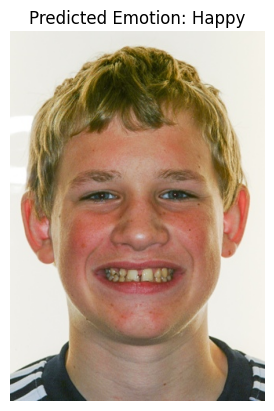

In [107]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Load and preprocess the image
img_path = '/kaggle/input/testing/Full-face-Frontal-Smiling.png'  

op = image.load_img(img_path)
img = image.load_img(img_path, target_size=(48, 48))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0  

prediction = vgg_model.predict(img_array)
predicted_class = np.argmax(prediction)

plt.imshow(op)
plt.title("Predicted Emotion: " + emotions[predicted_class])
plt.axis('off')  
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


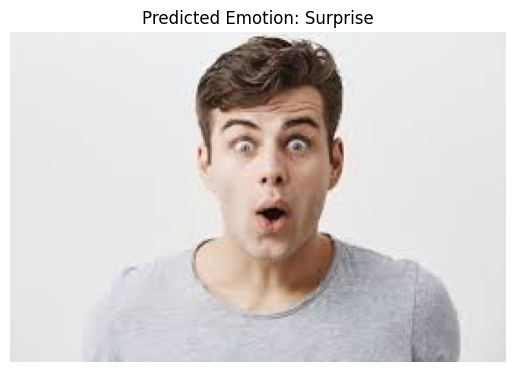

In [97]:
img_path = '/kaggle/input/testuu/neek.jpeg'  

op = image.load_img(img_path)
img = image.load_img(img_path, target_size=(48, 48))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0  

prediction = vgg_model.predict(img_array)
predicted_class = np.argmax(prediction)

plt.imshow(op)
plt.title("Predicted Emotion: " + emotions[predicted_class])
plt.axis('off')  
plt.show()